How often are certain page types visited (search, item, home etc.)


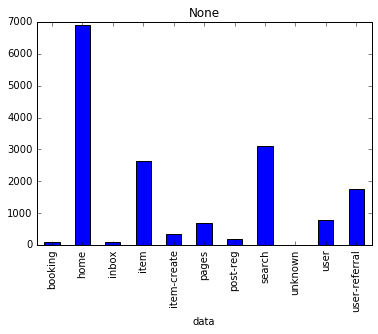

data
booking            88
home             6893
inbox              91
item             2640
item-create       354
pages             692
post-reg          184
search           3098
unknown            13
user              782
user-referral    1756
dtype: int64

In [15]:
import pandas as pd
from matplotlib import pyplot as plt
% matplotlib inline

df = pd.read_hdf("filtered_data.hdf", "df1")

def page_entity(page):
    p = False
    if page == "/" or page == '/home' or "?ref=" in page or page == 'x/home':
        p = 'home'
    if "/item/" in page:
        p = 'item'
    if "/p/" in page:
        p = 'pages'
    if "/user/" in page:
        p = 'user'
    if "/user/refe" in page:
        p = 'user-referral'
    if "/search" in page:
        p = 'search'
    if "/inbo" in page:
        p = 'inbox'
    if "/booking/" in page:
        p = 'booking'
    if "/item/create" in page:
        p = 'item-create'
    if "/user/registration/post-registration" in page:
        p = 'post-reg'
    if p == False:
        p = 'unknown'
    return p

df.data = df.data.apply(lambda x: page_entity(x))
df_pv = df[df.source == 1]
df_pv = df_pv[df_pv.type == 'page_view']
cnt_df = df_pv.data.groupby(df_pv.data).count()
cnt_df.plot(kind="bar", subplots=True)

plt.show()
cnt_df

How often do users return to our site, how many sessions?


In [71]:
df = pd.read_hdf("filtered_data.hdf", "df1")
df = df[df.source == 1]
unique_sessions = df.session.nunique()
user_session = df[pd.notnull(df.user_id)].session.nunique()
print(df.session.nunique(), "Unique sessions")
print(df.user_id.nunique(), "Unique users")
print(df[pd.notnull(df.user_id)].session.nunique(), "Unique sessions from users")
print(df[pd.notnull(df.user_id)].session.nunique() / df.user_id.nunique(), "Avg sessions per user")
print((unique_sessions - user_session) / unique_sessions, "Percentage sessions from non-user")

6250 Unique sessions
437 Unique users
833 Unique sessions from users
1.9061784897025171 Avg sessions per user
0.86672 Percentage sessions from non-user


Where do a lot of users drop out (which pages)?

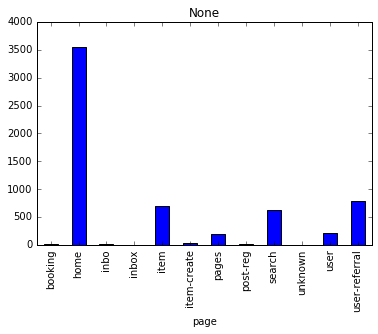

page
booking            10
home             3552
inbo               10
inbox               2
item              698
item-create        30
pages             206
post-reg           21
search            635
unknown             5
user              215
user-referral     795
dtype: int64

In [16]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
df = pd.read_hdf("filtered_data.hdf", "df1")
def page_entity(page):
    p = False
    if page == "/" or page == '/home' or "?ref=" in page or page == 'x/home':
        p = 'home'
    if "/item/" in page:
        p = 'item'
    if "/p/" in page:
        p = 'pages'
    if "/user/" in page:
        p = 'user'
    if "/user/refe" in page:
        p = 'user-referral'
    if "/search" in page:
        p = 'search'
    if "/inbo" in page:
        p = 'inbox'
    if "/booking/" in page:
        p = 'booking'
    if "/item/create" in page:
        p = 'item-create'
    if "/user/registration/post-registration" in page:
        p = 'post-reg'
    if p == False:
        p = 'unknown'
    return p

df.data = df.data.apply(lambda x: page_entity(x))
df = df[df.source == 1]
df = df[df.type == 'page_view']
df = df.sort_values('created_at', ascending=False)
df = df.groupby("session").agg(lambda x: "xxx".join(x))  # type: pd.DataFrame
leaving_pages = []
for i in df.itertuples():
    leaving_pages.append(i.data.split('xxx')[0])
    exit()
    
df = pd.DataFrame(leaving_pages)
df.columns = ["page"]
cnt_df = df['page'].groupby(df['page']).count()
cnt_df.plot(kind="bar", subplots=True)

plt.show()
cnt_df

Comparing the two outputs (the table from the top and this one), a lot of users drop out from the home page and the user-referral page. (50% and ~35% more or less). Item create pages, post registration, search have very low dropout, item page is somewhere in the middle (26.4%).

## Clustering the first 4 page visits of a user

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
df = pd.read_hdf("filtered_data.hdf", "df1")
df = df[df.source == 1]
df = df[df.type == 'page_view']
def page_entity(page):
    p = False
    if page == "/" or page == '/home' or "?ref=" in page or page == 'x/home':
        p = 'home'
    if "/item/" in page:
        p = 'item'
    if "/p/" in page:
        p = 'pages'
    if "/user/" in page:
        p = 'user'
    if "/user/refe" in page:
        p = 'user-referral'
    if "/search" in page:
        p = 'search'
    if "/search?q=" in page:
        p = 'search-kw'    
    if "/inbo" in page:
        p = 'inbox'
    if "/booking/" in page:
        p = 'booking'
    if "/item/create" in page:
        p = 'item-create'
    if "/user/registration/post-registration" in page:
        p = 'post-reg'
    if p == False:
        p = 'unknown'
    return p
df = df.sort_values('created_at', ascending=True)
df = df.groupby("session").agg(lambda x: "xxx".join(x))  # type: pd.DataFrame
sessions = []
for i in df.itertuples():
    pages = i.data.split('xxx')
    user_pages = []
    if len(pages) < 4:
        continue
    for p in pages:
        if len(user_pages) >= 4:
            break
        user_pages.append(page_entity(p))
    
    sessions.append(user_pages)

df = pd.DataFrame(sessions)

df.to_csv("cluster.csv")

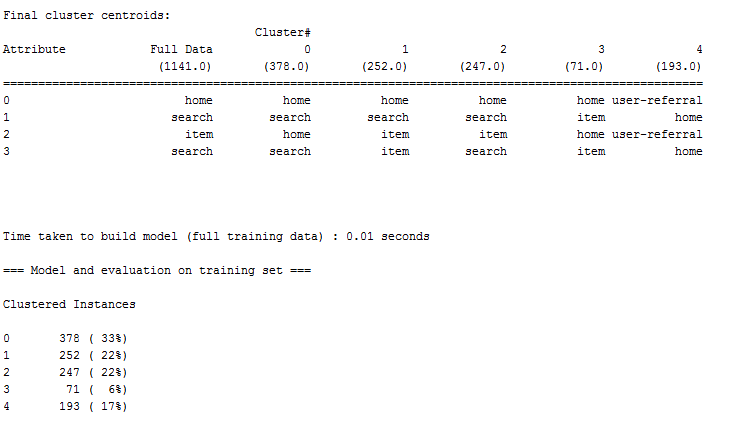

In [2]:
from IPython.display import Image
Image(filename='cluster/kmeans-5.png')

This leaves about 1100 user clickstreams. Clustering it into 5 clustres results in the above. Quite clearly almost all starting at home, you can see that search is the clear second page visit. After that, quite some users tend to go back home, while others start browsing items.